# Biodiversity Intactness Index Change in Phoenix, AZ
**Author**: Vedika Shirtekar

**Repository**: https://github.com/vedikaS-byte/eds-220-project-task2

## About

### Purpose
Maricopa County, the fourth most populous county in the United States, is home to more than half of Arizona's residents and contains the state capital, Phoenix. As of 2022, the county had a population of 4.5 million people and was listed as the fastest-growing county in the U.S., adding nearly 56,000 residents between July 2021 and 2022 (Maricopa County, n.d.). This rapid population growth has contributed to the most significant increase in developed land in the county since at least 2001 (Levitt & Eng, 2021). Consequently, expanding urban sprawl has raised concerns about impacts on biodiversity and ecosystem health in the surrounding areas.



This assignment investigates urban sprawl impacts on diversity by analyzing Biodiversity Intactness Index (BII) values in the Phoenix county subdivision area for 2017 and 2020. The analysis highlights how urban growth corresponds with changes in biodiversity over time, providing insight into the ecological consequences of expanding urban landscapes. The final output consists of a map illustrating changes in BII over time across the Phoenix metropolitan area, highlighting areas of biodiversity loss.

### Highlights
Three key highlights were identified in the analysis: 

1. **Load a raster from a catalog of diverse geospatial datasets to access standardized environmental information for the study area of interest.**

2. **Create a mask by selecting raster cells that meet a specific condition (ex. BII >= .75 in a select year).**

3. **Ensure the shapefile and raster share the same coordinate reference system (CRS) to prevent misalignment and enable accurate spatial calculations.**

### Data Description 

Biodiversity Intactness Index (BII) Time Series: Access the io-biodiversity collection from the Microsoft Planetary Computer STAC catalog. Use the 2017 and 2020 rasters covering the Phoenix subdivision. For the bounding box, use the following coordinates:
[-112.826843, 32.974108, -111.184387, 33.863574]


### Data References


## Import and Read in Data
Import the neccessary libraries and read in the County shapefiles.  

In [1]:
# Import necessary libraries along with defined abbreviations
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd 
import xarray as xarray
import contextily as ctx
import rioxarray as rioxr
from shapely import box
from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 

#from IPython.display import Image  # To nicely display images

In [2]:
# Set up display options when looking at data frames
pd.set_option("display.max.columns", None)

# Establish file path to read in shapefile
az_fp = os.path.join("data", "tl_2025_04_cousub", 
                        "tl_2025_04_cousub.shp")
az = gpd.read_file(az_fp)

## Data Exploration

### Exploring the Phoenix Subdivision Shapefile

In [3]:
# Isolate for just Phoenix (Maricopa County)
phoenix = az[az["NAME"] == "Phoenix"]

In [85]:
# View the first few rows
phoenix.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
69,04,013,92601,01934968,0401392601,0600000US0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,S,2806469278,9424955,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


In [87]:
# Explore data types, dimensions, and additional attributes
phoenix.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1 entries, 69 to 69
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   1 non-null      object  
 1   COUNTYFP  1 non-null      object  
 2   COUSUBFP  1 non-null      object  
 3   COUSUBNS  1 non-null      object  
 4   GEOID     1 non-null      object  
 5   GEOIDFQ   1 non-null      object  
 6   NAME      1 non-null      object  
 7   NAMELSAD  1 non-null      object  
 8   LSAD      1 non-null      object  
 9   CLASSFP   1 non-null      object  
 10  MTFCC     1 non-null      object  
 11  FUNCSTAT  1 non-null      object  
 12  ALAND     1 non-null      int64   
 13  AWATER    1 non-null      int64   
 14  INTPTLAT  1 non-null      object  
 15  INTPTLON  1 non-null      object  
 16  geometry  1 non-null      geometry
dtypes: geometry(1), int64(2), object(14)
memory usage: 144.0+ bytes


In [89]:
# Check the projected CRS
print(f"CRS of Phoenix shapefile: {phoenix.crs.name} ({phoenix.crs.to_epsg()}).") 

CRS of Phoenix shapefile: WGS 84 (4326).


The `contextily` library was used to add a basemap, providing geographic context for the Phoenix metropolitan area.

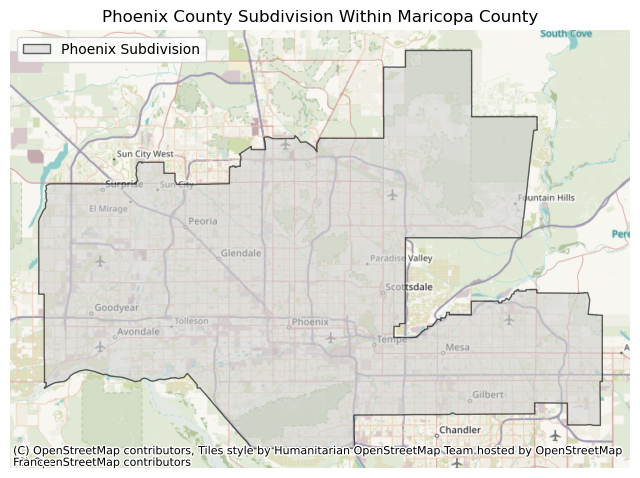

In [96]:
# Map of Phoenix with basemap
fig, ax = plt.subplots(figsize = (8,8))

# Project Phoenix to correct CRS for preferred basemap
phoenix  = phoenix.to_crs(3857)

# Plot shapefile
phoenix.plot(ax= ax, edgecolor = "black", facecolor = "lightgrey", alpha = .6)

# Add appropriate basemap
ctx.add_basemap(ax, source = ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
)

# Set axis off
ax.set_axis_off()

# Set title
ax.set_title("Phoenix County Subdivision Within Maricopa County")

# Create patch for reference in legend
phoenix_outline = mpatches.Patch(facecolor = "lightgrey", edgecolor = "black", alpha = .6, label= "Phoenix Subdivision")
ax.legend(handles = [phoenix_outline], loc = "upper left")

# Call plot
plt.show()

The `phoenix` shapefile is a `geopandas.GeoDataFrame` containing a single observation with 16 variables of types `object`, `int64`, and `geometry`. Its CRS is WGS 84 (EPSG:4326). Based on the accompanying figure, the subdivision covers a large area and includes major cities such as Glendale, Phoenix, Scottsdale, and Mesa.

## Extracting BII Rasters from the Microsoft Planetary Computer Catalog
Rasters can be accessed directly from an online catalog database. To open the catalog, use `Client.open()` and provide the URL for the catalog directory. When opening the catalog, a modifier such as `modifier=planetary_computer.sign_inplace` can be specified to configure access to the dataset. To extract the desired dataset, use the collection code "io-biodiversity" to retrieve the collections associated with the BII.

In [4]:
# Open MPC STAC Catelog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier = planetary_computer.sign_inplace)

# Pull out BII collection
bii_collection = catalog.get_child("io-biodiversity")
bii_collection

<CollectionClient id=io-biodiversity>

It is also necessary to define a bounding box for further analysis, such as clipping. In this case, define the bounding box with the coordinates [-112.826843, 32.974108, -111.184387, 33.863574].

In [5]:
# Define bounding box
phoenix_bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

Search the BII collection within the Phoenix bounding box for 2017 and 2020. Then, select the first STAC item from each year's results to use in the analysis.

In [6]:
# Search for BII collection within bbox
search_2017 = catalog.search(
    collections = ["io-biodiversity"], 
    bbox = phoenix_bbox, 
    datetime = "2017-01-01/2017-12-31" # Grab range for years
)


search_2020 = catalog.search(
    collections = ["io-biodiversity"], 
    bbox = phoenix_bbox, 
    datetime = "2020-01-01/2020-12-31" # Grab range for year
)

# Return first STAC item from search year result
items_2017 = list(search_2017.items())[0]
items_2020 = list(search_2020.items())[0]

Once the first item is identified for each year, the raster can be opened. Use `assets.keys()` to view the available assets and select the appropriate key as a reference in `open_rasterio` via the `rioxarray` accessor. Repeat this process to open both the 2017 and 2020 rasters, and use `squeeze()` to drop the singular band so that the raster has the correct dimensions.

In [7]:
# Determine reference term for assests
items_2017.assets.keys()

dict_keys(['data', 'tilejson', 'rendered_preview'])

In [8]:
# Open raster for 2017 
bii_2017 = rioxr.open_rasterio(items_2017.assets['data'].href)

# Squeeze to remove length 1 dimension (band)
bii_2017 = bii_2017.squeeze().drop_vars('band')

In [9]:
# Open raster for 2020
bii_2020 = rioxr.open_rasterio(items_2020.assets['data'].href)

# Squeeze to remove length 1 dimension (band)
bii_2020 = bii_2020.squeeze().drop_vars('band')

Ensure that the CRS of the raster (`xarray.DataArray`) and the shapefile match to prevent misalignment.

In [10]:
# Perform check with conditional statements
print(f" The Phoenix shapefile CRS is currently: {phoenix.crs.to_epsg()}")

if (phoenix.crs != bii_2017.rio.crs):
    phoenix = phoenix.to_crs(bii_2017.rio.crs)
    
print(f" The 2017 BII raster CRS is currently: {bii_2017.rio.crs.to_epsg()}")

print(f" The Phoenix shapefile CRS is now: {phoenix.crs.to_epsg()}")

 The Phoenix shapefile CRS is currently: 4269
 The 2017 BII raster CRS is currently: 4326
 The Phoenix shapefile CRS is now: 4326


Create a `GeoDataFrame` representing the bounding box of the 2017 raster to use as a spatial reference. Then, clip both the 2017 and 2020 BII rasters to the Phoenix subdivision geometry, ensuring both align with the shapefile CRS. Plot the clipped 2017 and 2020 rasters to visualize the specified bounded area of interest

In [11]:
# Create GeoDataFrame from raster bounding box (use bii_2017 as reference)
raster_bbox = gpd.GeoDataFrame(geometry = [box(*bii_2017.rio.bounds())],
                             crs = bii_2017.rio.crs)

In [12]:
# Clip each raster to the phoenix bounding box
bii_2017_clip = bii_2017.rio.clip(phoenix.geometry, phoenix.crs)

In [13]:
# Clip each raster to the phoenix bounding box
bii_2020_clip = bii_2020.rio.clip(phoenix.geometry, phoenix.crs)

[Text(0, 33.2, ''),
 Text(0, 33.300000000000004, ''),
 Text(0, 33.400000000000006, ''),
 Text(0, 33.5, ''),
 Text(0, 33.6, ''),
 Text(0, 33.7, ''),
 Text(0, 33.800000000000004, ''),
 Text(0, 33.900000000000006, '')]

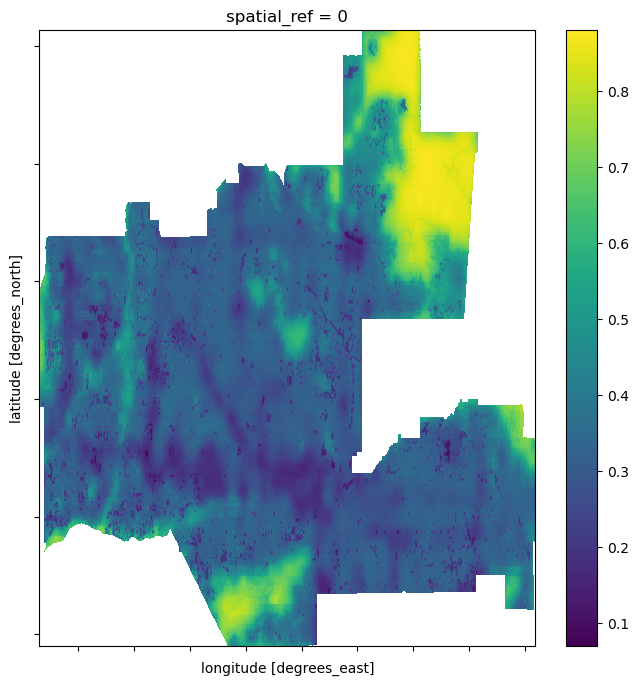

In [99]:
# One band is expected since one index
fig, ax = plt.subplots(figsize = (8,8))
bii_2017_clip.plot(ax=ax)

ax.set_xticklabels([]) # Turn off x axis
ax.set_yticklabels([])  # Turn off y axis

[Text(0, 33.2, ''),
 Text(0, 33.300000000000004, ''),
 Text(0, 33.400000000000006, ''),
 Text(0, 33.5, ''),
 Text(0, 33.6, ''),
 Text(0, 33.7, ''),
 Text(0, 33.800000000000004, ''),
 Text(0, 33.900000000000006, '')]

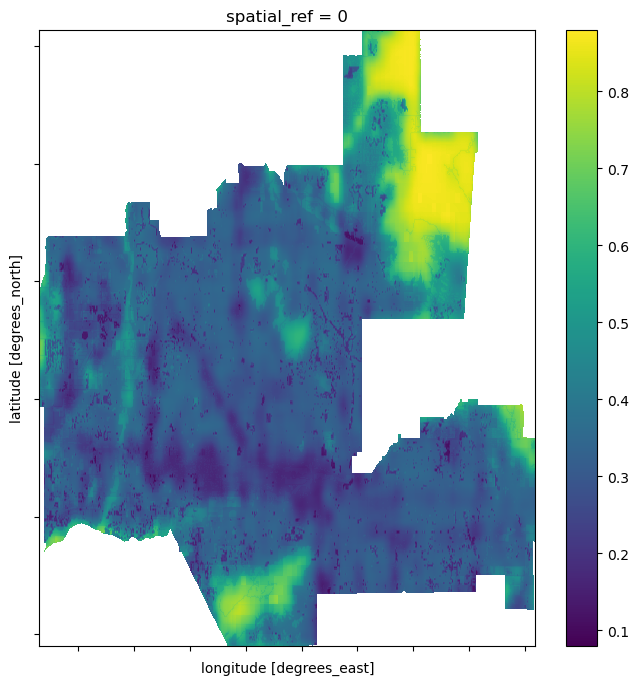

In [35]:
# One band is expected since one index
fig, ax = plt.subplots(figsize = (8,8))
bii_2020_clip.plot(ax=ax)

# Turn of axis labels
ax.set_xticklabels([]) # Turn off x axis
ax.set_yticklabels([])  # Turn off y axis

## Identifying Temporal Losses in BII Area 
To identify losses in BII area between 2017 and 2020, create spatial masks for raster pixels with BII values greater than or equal to .75 to isolate areas of high biodiversity between 2017 and 2020. Create a difference mask 

In [16]:
# Identify B11 values exceeding .75
exceed_2017 = bii_2017_clip >= .75 # T if exceeded, F is not
exceed_2020 = bii_2020_clip >= .75  # T if exceeded, F is not

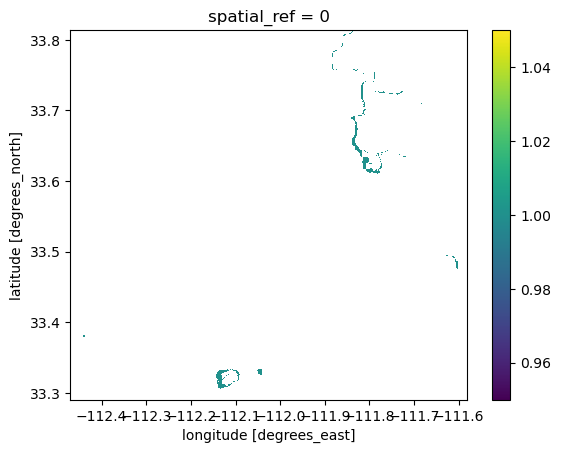

In [83]:
# Create a difference mask to identify where status changed between two years
diff_mask = exceed_2017 ^ exceed_2020

# Include only changed pixels and set others to NaN
loss_numeric = diff_mask.where(diff_mask, other = np.nan)

# Plot areas to visualize where BII changed
loss_numeric.plot()

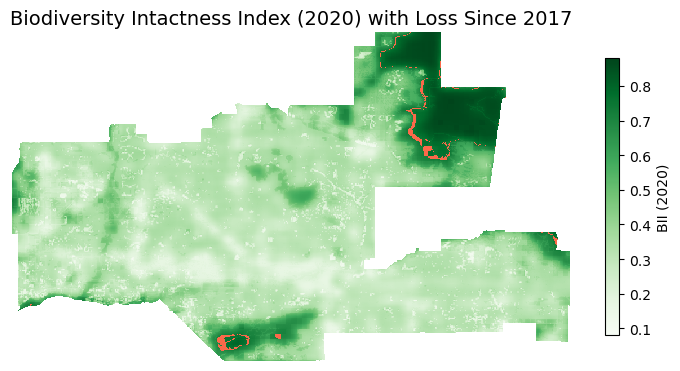

In [102]:
fig, ax = plt.subplots(figsize=(9,9))

bii_2020_clip.plot(
    ax=ax,
    cmap="Greens",
    add_colorbar=True, 
    cbar_kwargs = {"shrink":.4, "label": "BII (2020)"}
)


loss_numeric.plot(
    ax=ax,
    cmap= "Reds",
    add_colorbar=False
)

# Establish Phoenix boundary for reference
phoenix.boundary.plot(ax=ax, edgecolor="black", linewidth=1.5)

ax.set_title("Biodiversity Intactness Index (2020) with Loss Since 2017 in the Phoenix Subdivision", fontsize=14)
ax.set_axis_off()

plt.show()